# Tomographie à rayons X


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import rotate, resize
import time

On commence par charger une image synthétique (le "Shepp-Logan phantom") dont on fixe la taille à 256 x 256 pixels. Le Shepp-Logan phantom est une image de test standard créée par Larry Shepp et Benjamin F. Logan en 1974et qui sert de modèle d'acquisition d'une tête humaine dans le développement et le test d'algorithmes de reconstruction d'images.

In [2]:
# Load the image
N = 256
image = shepp_logan_phantom()
image = resize(image, (N, N), anti_aliasing=True)

## 1. Transformée de Radon

**En utilisant la fonction *rotate* de scikit-image, implémenter une fonction permettant de calculer la transformée de Radon d'une image, appelée également sinogramme de l'image.**

Pour un angle donné, on peut calculer la transformée de Radon de l'image en appliquant une rotation à l'image dans le sens inverse des aiguilles d'une montre et en sommant la valeur des pixels de l'image obtenue après rotation ligne par ligne.

In [3]:
def radon_transform(image, theta):
    
    """
    Computes the Radon transform of the image

    Parameters
    ----------
    
    image: 2D numpy array
      input image
      
    theta: 1D numpy array
      angles (specified in degrees)
    
    Return
    ------
    
    out: numpy array
      Radon transform (sinogram) of the input image
      
    """
    randon_transform=np.zeros((len(theta),image.shape[0]))
    for i in range(len(theta)):
      rotate_image=rotate(image,theta[i])
      randon_transform[i,:]=rotate_image.sum(axis=1)
    return randon_transform
    #TODO: Implement the Radon transgorm


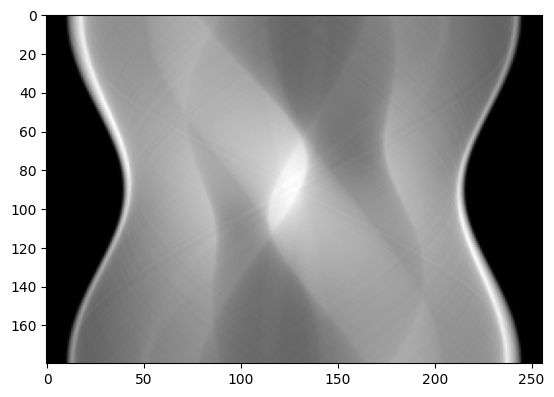

In [4]:
# Computes the Radon transform of the image 
N_t = 256
angles_count = 180
theta = np.linspace(0., 180., angles_count, endpoint=False)
sinogram = radon_transform(image, theta=theta)
plt.imshow(sinogram, cmap='gray')

Text(0.5, 1.0, 'Sinogram')

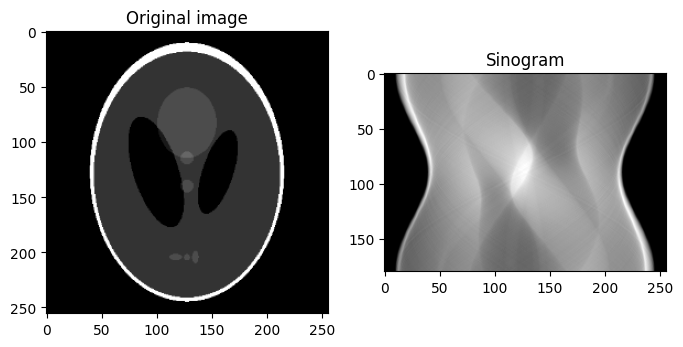

In [5]:
# Display the original image along with its sinogram
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(122)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram')


### Question 1.2 :

Posons  $ h_\theta : t \mapsto R_f(\theta, t) $.

On a:

$$ \hat{h_\theta}(\omega) = \int_{\mathbb{R}} h_\theta(t) e^{-i\omega t} \> dt = \iint_{\mathbb{R}^2} f(t cos(\theta) - \rho sin(\theta), t sin(\theta) + \rho cos(\theta)) e^{-i\omega t} \> d\rho dt $$

Or $ \binom{x}{y} = R_{\theta} \binom{t}{\rho} $ où $ R_{\theta} $ est la matrice de rotation d'angle $\theta$ dont le déterminant vaut donc 1. On obtient ainsi par changement de variable: 

$$ \hat{h_\theta}(\omega) = \iint_{\mathbb{R}^2} f(x, y) e^{-i\omega (x cos(\theta) + y sin(\theta))} \> dx dy = F_f(\omega cos(\theta), \omega sin(\theta)) $$

Ce qui est le résultat attendu.

## 2. Rétroprojection

**Implémenter la reconstruction de l'image tomographique à partir du sinogramme par rétro-projection. Commenter le résultat.**

### Question 2.1 :

Avec $ f = \mathbb{1}_{r \le 1} $ la fonction indicatrice de la boule unité fermée, on a:

$$ R_f(\theta, t) = \int_{-\infty}^{+\infty} \mathbb{1}_{r \le 1} (t cos(\theta) - \rho sin(\theta), t sin(\theta) + \rho cos(\theta)) \> d\rho = \int_{-\infty}^{+\infty} \mathbb{1}_{r \le 1} (t, \rho) \> d\rho $$

car $ R_\theta $ est une isométrie.
On a $ t^2 + \rho ^2 \le 1 $ ssi $ -\sqrt{1 - t^2} \le \rho \le \sqrt{1 - t^2}$ et $ |t| \le 1 $ d'où:

$$ R_f(\theta, t) = \mathbb{1}_{|t| \le 1} \> 2 \sqrt{1 - t^2} $$

Si $ t = x cos(\theta) + y sin(\theta) $, alors, avec $ x = r cos(\gamma), \> y = r sin(\gamma) $ et $r = \left\| \binom{x}{y} \right\|$, on a $|t| = |x cos(\theta) + y sin(\theta)| = r |cos(\theta - \gamma)|$.

Ainsi: 

$$ \tilde{f}(x, y) = {1 \over \pi} \mathbb{1}_{|x cos(\theta) + y sin(\theta)| \le 1} \int_{0}^{\pi} 2.\mathbb{1}_{[-1,1]}(x cos(\theta) + y sin(\theta)) \sqrt{1 - (x cos(\theta) + y sin(\theta))^2} \> d\theta $$

Comme il existe des directions $\gamma$ selon lesquelles $|t| \le 1$ même pour r > 1, la fonction $\tilde{f}$ n'est donc pas nulle à l'extérieur de la boule unité. Ainsi, la formule de rétroprojection n'est donc pas une formule d'inversion.

In [6]:
def backproj(g, N_t, angles_count, N):
    
    """
    Backprojection
    
    Parameters
    ----------
    
    g: N_t x angle_count array
      image sinogram
    N_t: int
      number of projection positions
    angles_count: int
      number of angular projections
    N: int
      image size
      
    Return
    ------
    
    reconstructed: N x N numpy array
      reconstructed image
    """
    recontructed = np.zeros((N, N))
    for i in range(N_t):
        for j in range(N_t):
            for k in range(angles_count):
                theta=np.pi * k  / angles_count
                t=int((i-N_t//2)*np.cos(theta)+(j-N_t//2)*np.sin(theta))
                if t<N_t/2:
                  recontructed[i,j] += g[k,N_t//2+t]
                
    return recontructed


In [7]:
# Backprojection of the sinogram
f = backproj(sinogram, N_t, angles_count, N)

Text(0.5, 1.0, 'Sinogram')

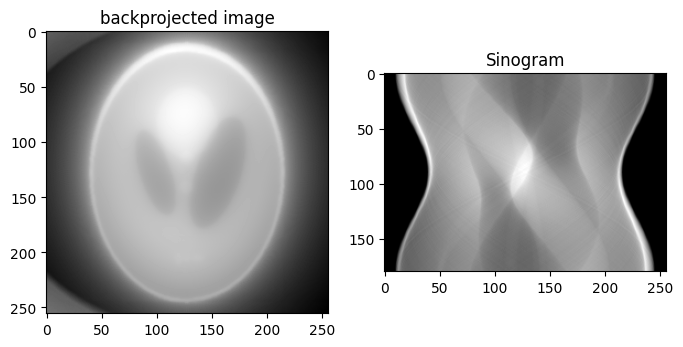

In [8]:
# Display the result
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(f, cmap='gray')
plt.title('backprojected image')
plt.subplot(122)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram')

##  2. Rétro-projection filtrée

**Appliquer un filtrage adapté au sinogramme avant de rétro-projeter. Afficher le sinogramme filtré ainsi que le résultat de la reconstruction.**


In [9]:
def filter_sinogram(sinogram, N_t):

    """
    Filter the sinogram
    
    Parameters
    ----------
    
    sinogram: numpy array
      sinogram
    N_t: int
      number of projection positions
      
    Return
    ------
    
    reconstructed: N_t x angle_counts numpy array
      reconstructed sinogram
    """

    # Création de la filtre dans le domaine de la fréquence
    w = np.fft.fftfreq(N_t, d=1.)
    w_filter = np.abs(w)  # Filtre |w|
    fft_sinogram = np.fft.fft(sinogram, axis=1)
    filtered_sinogram = np.fft.ifft(fft_sinogram * w_filter, axis=1)
    return filtered_sinogram.real
    # TODO: implement the filtering

In [10]:
filtered_sinogram = filter_sinogram(sinogram, N_t)

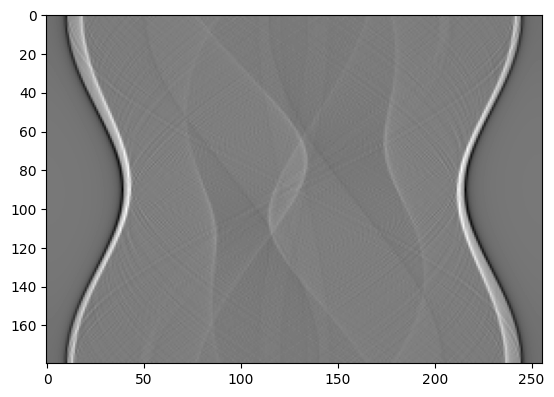

In [11]:
# Display the sinogram and the filtered sinogram
plt.imshow(filtered_sinogram, cmap='gray')

Text(0.5, 1.0, 'Filtered backpropagation image')

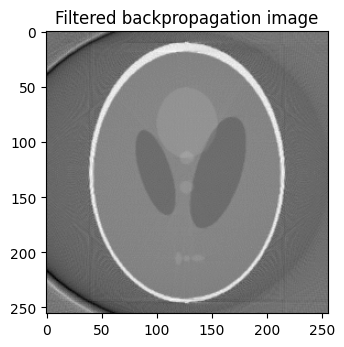

In [12]:
# Filtered backpropagation
frec = backproj(filtered_sinogram, N_t, angles_count, N)
# Display the reconstructed and the original images
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(frec, cmap='gray')
plt.title('Filtered backpropagation image')

### Question 2.4

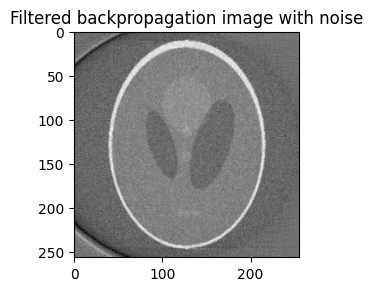

In [13]:
#ajout d'un bruit haute fréquence dans l'image
image_bruit = image + 0.1 * np.random.randn(N, N)
# Compute the sinogram
sinogram = radon_transform(image_bruit, theta=theta)
# Filter the sinogram
filtered_sinogram = filter_sinogram(sinogram, N_t)
# Filtered backprojection
frec = backproj(filtered_sinogram, N_t, angles_count, N)
# Display the reconstructed and the original images
plt.subplot(122)
plt.imshow(frec, cmap='gray')
plt.title('Filtered backpropagation image with noise')
plt.show()

# La méthode de filtrage n'a pas d'effet sur les hautes fréquences.

##  3. Approche par compressed sensingétro-projection filtrée



### Question 3.2.1.a)

Le lagrangien du système est défini par $ \mathcal{L}: (f, \lambda) \mapsto f^T f + \lambda ^T (Af - b) $

Un point stationnaire de $\mathcal{L}$ vérifie:

$$ f^* + A^T \lambda ^* = 0 $$
$$ A x^* = b $$

En multipliant la première équation par A on obtient: $b + AA^T \lambda ^* = 0$, or A est de rang plein, donc $AA^T$ est inversible, d'où $\lambda ^* = - (AA^T)^{-1}b$ et donc :

$$ f^* = A^T (AA^T)^{-1} b $$

In [14]:
from numpy.linalg import lstsq
from utils import Sensor
N=16
image_16 = shepp_logan_phantom()
image_16 = resize(image_16, (N, N), anti_aliasing=True)
sensor = Sensor(N, N*N//2-1)
F, M = sensor.get_measurement_matrix()
TF = np.dot(F, image_16.ravel())
m0 = np.zeros(N**2, dtype=np.complex128)
m0[sensor.indices] = TF[sensor.indices]
m = np.dot(M, image_16.ravel())

### Question 3.2.1.b)

"\nLa fonction lstsq ne s'intéresse pas qu'aux solutions réelles, et comme M et b sont constitués de complexes, la solution\nne sera à priori pas réelle.\n"

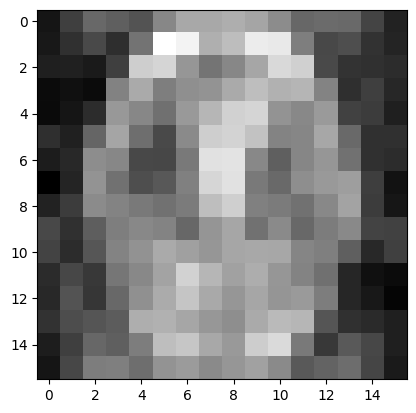

In [15]:
x = lstsq(M, m, rcond=None)[0]
x = x.reshape(N, N).real
plt.imshow(x, cmap='gray')

"""
La fonction lstsq ne s'intéresse pas qu'aux solutions réelles, et comme M et b sont constitués de complexes, la solution
ne sera à priori pas réelle.
"""

### Question 3.2.1.c)

On peut réécrire le problème (4) de la façon suivante :

En posant $M = A + iB$ et $m = a +ib$ la condition se réécrit comme :

$$ Mf = m \Leftrightarrow Af = a, \> Bf = b \Leftrightarrow \binom{A}{B} f = \binom{a}{b} $$

Où $\binom{A}{B} \in \mathbb{R}^{2p \times n}$ et $\binom{a}{b} \in \mathbb{R}^{2p}$.

Pour qu'il soit sous la forme de (5), il faut que $2p < n$ et $rg\binom{A}{B} = 2p$.

Comme nous choisissons p, nous pouvons arbitrairement le prendre assez petit, et nous pouvons considérer le système extrait dans lequel la matrice extraite de $\binom{A}{B}$ est de rang plein, car ce système est équivalent. 

Il se trouve que la fonction lstsq trouve la solution même pour p grand et $\binom{A}{B}$ de rang quelconque.

### Question 3.2.1.d)

D'après la formule de Parseval pour la TFD, on a : $\left\| f \right\|^2 = {1 \over n} \left\| \mathcal{F}f \right\|^2$, ce qui fait que les deux problèmes sont les mêmes à une pondération strictement positive près.

Soit $f$ une solution de (6), on a : $ \mathcal{F}f^* = m^{tot} $ où $m^{tot} = m^0 + m^1$ correspond au vecteur constitué de tous les coefficients de Fourier, $m^0$ correspond au vecteur constitué des mesures m et complété par des coefficients nuls pour les coordonnées non-mesurées, et $m^1$ correspond au vecteur constitué des coefficients des coordonnées non-mesurées et complété par des zéros.

La condition $Mf = m$ implique que les coefficients non-nuls de $m^0$ sont ceux de $m$.

Ainsi, 

$$ \forall f \in \mathbb{R}^n, \left\| \mathcal{F}f \right\|^2 = \left\| m^0 \right\|^2 + \left\| m^1 \right\|^2 = \left\| m \right\|^2 + \left\| m^1 \right\|^2 \ge \left\| m \right\|^2 $$

Ce minimum est atteint quand $m^1 = 0$ soit $f = \overline{\mathcal{F}}m^0$.

### Question 3.2.2.a)

On a :

$$ {1 \over 2} \left\| Mf - m \right\|^2 + \mu \left\| f \right\|^2 = {1 \over 2} \left\langle Mf | Mf \right\rangle - Re\left\langle Mf | m \right\rangle  + {1 \over 2} \left\| m \right\|^2 + \mu \left\langle f|f \right\rangle = {1 \over 2} f^T (M^\dagger M + 2 \mu I)f - Re(m^\dagger M) f + {1 \over 2} m^\dagger m $$

On a bien $ M^\dagger M + 2 \mu I $ symétrique définie positive, $Re(m^\dagger M)^T \in \mathbb{R}^n$ et ${1 \over 2} m^\dagger m \ge 0$.
En revanche la matrice n'est pas réelle

$*$ sert ici pour désigner le conjugé . On travaille de plus avec le produit hermitien car les  matrices sont complexes. 

Puisque $||Mf - m||^2 = (Mf - m)^{*T}(Mf - m)$ est un scalaire, il est égal à sa transposée et on a donc : 
$$2 ||Mf - m||^2 = (Mf - m)^{*T}(Mf - m) + \bigg((Mf - m)^{*T}(Mf - m)\bigg)^T$$

Utilisons la linéarité de la transposition, de la conjugaison, la stabilité par produit dans $\mathbb{C}$ de la conjugaison, et le fait que $f$ est à coefficients réels : les deux termes s'écrivent respectivement
$$ (Mf - m)^{*T}(Mf - m) = f^{*T}M^{*T}Mf - m^{*T}Mf - f^{*T}M^{*T}m + m^{*T}m= f^{T}M^{*T}Mf - m^{*T}Mf - f^{T}M^{*T}m + m^{*T}m$$
$$= f^{T}M^{*T}Mf - m^{*T}Mf - m^TM^*f + m^{*T}m= f^{T}M^{*T}Mf - \bigg(m^{*T}M + (m^{*T}M)^*\bigg)f + m^{*T}m= f^{T}M^{*T}Mf - 2Re(m^{*T}M)f + ||m||^2 $$
avec $Re(m^{*T}M)$ le vecteur des parties réelles des coefficients de $m^{*T}M$, et 
$$\bigg((Mf - m)^{*T}(Mf - m)\bigg)^T = \bigg(f^{T}M^{*T}Mf - 2Re(m^{*T}M)f + m^{*T}m\bigg)^T
= f^TM^TM^*f - 2Re(m^{*T}M)f + m^{*T}m$$
d'où

$$2 ||Mf - m||^2 = f^T(M^{*T}M + M^TM^*)f - 4Re(m^{*T}M)f + 2||m||^2$$
et finalement

$$\frac{1}{2}||Mf - m||^2 + \mu||f||^2 = f^T\bigg(\frac{1}{2}(M^{*T}M + M^TM^*) + \mu I\bigg)f - Re(m^{*T}M)f + \frac{1}{2}||m||^2 $$
Posons $Q' = \frac{1}{2}(M^{*T}M + M^TM^*)$. Notons que M n'est pas carrée. On a



$$2Q'_{i,j} = \sum_{k} M_{ki}^*M_{kj} + M_{ki}M_{kj}^*
= \sum_{k} 2Re(M_{ki}^*M_{kj})$$


donc $Q'$ est une matrice réelle.


Soit $x \in \mathbb{R}^n$. 

$$2x^TQ'x = x^TM^{*T}Mx + x^TM^TM^*x 
= x^TM^{*T}Mx + (x^TM^TM^*x)^T 
= x^TM^{*T}Mx + x^TM^{*T}Mx $$
donc $x^TQ'x = ||Mx||^2 \geq 0$. 

Donc $Q'$ est positive

Ainsi $Q=Q'+2\mu I$ est réelle et définie positive 

En conclusion, en posant $a = - Re(M^Tm^{*})$ et $c = \frac{1}{2}||m||^2$, on a 
$$
\frac{1}{2}||Mf - m||^2 + \mu||f||^2 = \frac{1}{2}f^TQf + a^Tf + c
$$
avec $Q$, $a$ et $c$ vérifient les propriétés demandées. 

### Question 3.2.2.b)

Soit $h : x \mapsto  \frac{1}{2}f^TQf + a^Tf + c $.

On a un problème convexe et différentiable, $f^*$ est un minimiseur ssi $\nabla h(f^*) = 0$.

$$ \nabla h(f) = Qf + a $$

Supposons $\mu > 0$, alors $Q$ est inversible et:

$$ f^* = -Q^{-1} a $$

### Question 3.2.2.c)

0.2639591693878174
0.20087003707885742


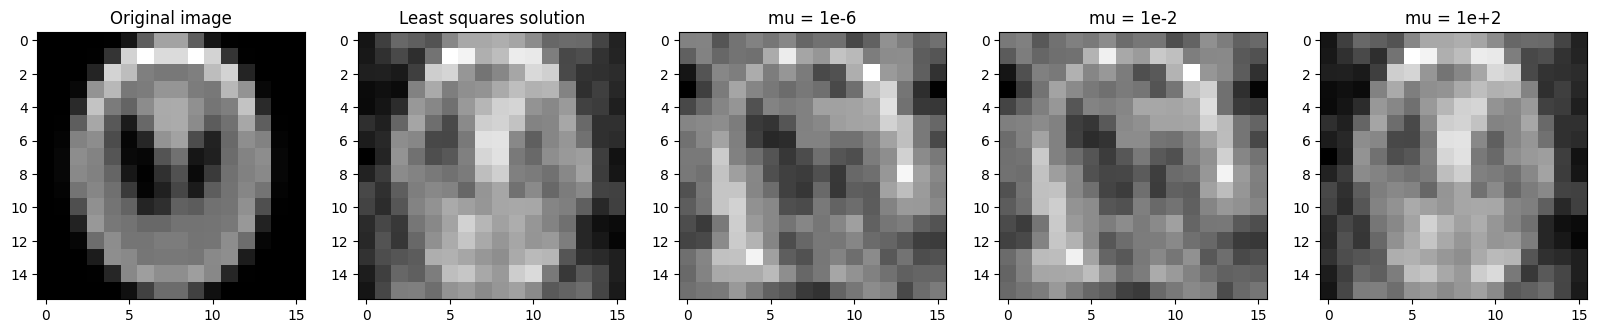

In [16]:
# Solution moindres carrés
time_start = time.time()
f_sol1 = np.dot(np.linalg.inv(F), m0).real.reshape(N, N)
time_end = time.time()
print( time_end - time_start)

# Solution moindres carrés régularisés

def regularized_least_squares(mu):
    M_dague = np.conjugate(np.transpose(M))
    m_dague = np.conjugate(np.transpose(m))
    Q = np.dot(M_dague, M) + 2*mu*np.eye(N*N)
    a = np.transpose(np.dot(m_dague, M).real)
    return np.dot(np.linalg.inv(Q), a).real.reshape(N, N)
time_start = time.time()
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))
ax1.imshow(image_16, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(f_sol1, cmap='gray')
ax2.set_title('Least squares solution')
ax3.imshow(regularized_least_squares(10**-6), cmap='gray')
ax3.set_title('mu = 1e-6')
ax4.imshow(regularized_least_squares(10**-2), cmap='gray')
ax4.set_title('mu = 1e-2')
ax5.imshow(regularized_least_squares(10**2), cmap='gray')
ax5.set_title('mu = 1e+2')
time_end = time.time()
print( time_end - time_start)

plt.show()

### Question 3.2.3.a)

Soit $ s_+, s_- \ge 0$ tel que $ D_g f = s_+ - s_-$, alors $\left\| D_g f \right\|_1 = \bold{1}^T s_+ + \bold{1}^T s_- $.

Or $ D_g f = s_+^* - s_-^*$ où $ s_+^* = max(D_g f, 0) $  et $ s_-^* = max(-D_g f, 0) $, on a donc $\left\| D_g f \right\|_1 \ge \underset{s_+, s_- \ge 0}{inf} \underset{tq D_g f = s_+ - s_-}{\bold{1}^T s_+ + \bold{1}^T s_-} $.

De plus, $\left\| D_g f \right\|_1 = \sum_{i = 0}^{n - 1} |s_+^i - s_-^i| \le \sum_{i = 0}^{n - 1} s_+^i + s_-^i = \bold{1}^T s_+ + \bold{1}^T s_- $ par inégalité triangulaire.
Donc $\left\| D_g f \right\|_1 \le \underset{s_+, s_- \ge 0}{inf} \underset{tq D_g f = s_+ - s_-}{\bold{1}^T s_+ + \bold{1}^T s_-} $

Ainsi,
$$ \left\| D_g f \right\|_1 = \underset{s_+, s_- \ge 0}{inf} \underset{tq D_g f = s_+ - s_-}{\bold{1}^T s_+ + \bold{1}^T s_-} $$

On a donc;

$$ \underset{f \in \mathbb{R}^n}{inf} \quad \frac{1}{2} \left\| Mf - m \right\|^2 + \mu \left\| f \right\|_{TV} = \underset{f \in \mathbb{R}^n}{inf} ( \frac{1}{2} \left\| Mf - m \right\|^2 + \mu \underset{s_+, s_- \ge 0}{inf} \underset{tq D_g f = s_+ - s_-}{\bold{1}^T s_+ + \bold{1}^T s_-} ) \newline = \underset{f \in \mathbb{R}^n}{inf} (\underset{s_+, s_- \ge 0}{inf} \underset{tq D_g f = s_+ - s_-}{\frac{1}{2} \left\| Mf - m \right\|^2 + \mu (\bold{1}^T s_+ + \bold{1}^T s_-)}) \newline = \underset{f \in \mathbb{R}^n;\> s_+, s_- \ge 0;\> tq D_g \> f = s_+ - s_-}{inf} \frac{1}{2} \left\| Mf - m \right\|^2 + \mu (\bold{1}^T s_+ + \bold{1}^T s_-)$$

car le problème est convexe.

### Question 3.2.3.b)


Time elapsed: 0.6585893630981445
Time elapsed: 179.15012979507446


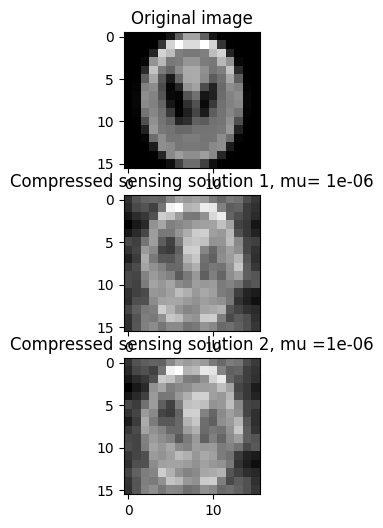

In [17]:
from scipy.optimize import minimize

# Implémentation de Dg

Dgh_1 = np.block([np.zeros((N*(N-1), N)), np.identity(N*(N-1))])
Dgh_2 = np.block([np.identity(N*(N-1)), np.zeros((N*(N-1), N))])
Dgh = Dgh_1 - Dgh_2

Delta = np.block([np.zeros(N-1).reshape(N-1, 1), np.identity(N-1)]) - np.block([np.identity(N-1), np.zeros(N-1).reshape(N-1, 1)])
Dgv = np.kron(np.eye(N,dtype=int), Delta)

Dg = np.block([[Dgh], [Dgv]])

# Fonction 1

def fun_compressed_sensing(f, mu):
    return 0.5*np.linalg.norm(np.dot(M, f) - m)**2 + mu*np.linalg.norm(np.dot(Dg, f), 1)

f0 = np.zeros(N*N)
mu = 10**-6
time_start = time.time()
res = minimize(fun_compressed_sensing, f0, args=(mu))
f_sol_1 = res.x.reshape(N, N)
time_end = time.time()
print(f"Time elapsed: {time_end - time_start}")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.imshow(image_16, cmap='gray')
ax1.set_title('Original image')
ax2.imshow(f_sol_1, cmap='gray')
ax2.set_title(f'Compressed sensing solution 1, mu= {mu}')

# Fonction 2

def fun_compressed_sensing_2(x, mu):

    f = x[0:N*N]
    s_p = x[N*N:N*N + 2*N*(N-1)]
    s_m = x[N*N + 2*N*(N-1):]

    return 0.5*np.linalg.norm(np.dot(M, f) - m)**2 + mu*np.sum(s_p) + mu*np.sum(s_m)

def condition_1(x):

    f = x[0:N*N]
    s_p = x[N*N:N*N + 2*N*(N-1)]
    s_m = x[N*N + 2*N*(N-1):]

    return np.dot(Dg, f) - (s_p - s_m)

def condition_2(x):
    return x[N*N:]

cons = [{'type':'eq', 'fun': condition_1},
        {'type':'ineq', 'fun': condition_2}]

x0 = np.zeros(4*N*(N-1) + N*N)
time_start = time.time()
res = minimize(fun_compressed_sensing_2, x0, args=(mu), constraints=cons)
f_sol_2 = res.x[0:N*N].reshape(N, N)
time_end = time.time()
print(f"Time elapsed: {time_end - time_start}")

ax3.imshow(f_sol_2, cmap='gray')
ax3.set_title(f'Compressed sensing solution 2, mu ={mu}')

plt.show()


### Question 3.2.3.c)

On travaille désormais avec le vecteur concaténé $(f, s^+, s^-)$. 

Posons 

$Q_e = \begin{pmatrix}
\frac{1}{2}\bigg(M^{*T}M + M^TM^*\bigg) &  &  \\
 & 0 &  \\
 &  & 0
\end{pmatrix}
\ \ a_e = \begin{pmatrix} a \\
\mu 1 \\
\mu 1
\end{pmatrix}$

$A=\begin{pmatrix}D_{g}&-I_{2N(N-1)}& I_{2N(N-1)}\end{pmatrix}$
$\ \ G=\begin{pmatrix}0&0&0&\\
0&-I_{2N(N-1)}&0&\\
0&0&-I_{2N(N-1)}
\end{pmatrix}$
 $\ \ c_e=\frac{1}{2}||m||^2$

le problème $(13)$ se met alors sous forme $(14)$

### Question 3.2.3.d)

     pcost       dcost       gap    pres   dres
 0: -1.4729e+00 -3.6946e-01  1e+03  4e+01  1e+01
 1: -5.2392e-01 -1.7156e+01  2e+01  6e-01  2e-01
 2: -6.2297e-01 -1.6433e+00  1e+00  6e-03  2e-03
 3: -1.4618e+00 -1.5019e+00  4e-02  1e-04  5e-05
 4: -1.4884e+00 -1.4964e+00  8e-03  2e-05  9e-06
 5: -1.4912e+00 -1.4944e+00  3e-03  9e-06  3e-06
 6: -1.4925e+00 -1.4935e+00  1e-03  2e-06  9e-07
 7: -1.4929e+00 -1.4932e+00  2e-04  4e-07  1e-07
 8: -1.4931e+00 -1.4931e+00  3e-05  3e-08  1e-08
 9: -1.4931e+00 -1.4931e+00  5e-06  3e-09  1e-09
10: -1.4931e+00 -1.4931e+00  2e-07  1e-10  4e-11
Optimal solution found.
Time elapsed:  2.238420009613037


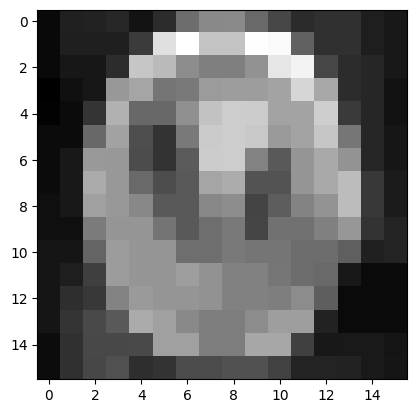

In [18]:

from cvxopt import matrix, solvers
from scipy import linalg
mu=10e-4
Qe=linalg.block_diag(np.dot(np.conjugate(np.transpose(M)), M)+np.dot(np.transpose(M),np.conjugate(M)),np.zeros((2*N*(N-1),2*N*(N-1))),np.zeros((2*N*(N-1),2*N*(N-1)))).real
ae =np.transpose(np.block([-np.dot(np.transpose(M),np.conjugate(m)).real, mu*np.ones(2*N*(N-1)), mu*np.ones(2*N*(N-1))]))
ce = 1/2*np.linalg.norm(m)**2
G = linalg.block_diag(np.zeros((N*N,N*N)), -np.eye(2*N*(N-1)), -np.eye(2*N*(N-1)))
h = np.zeros(N*N+4*N*(N-1))
A = np.block([Dg, -np.eye(2*N*(N-1)),np.eye(2*N*(N-1))])
b = np.zeros(2*N*(N-1)) # Votre vecteur b

# Convertir les matrices en matrices CVXOPT
Qe = matrix(Qe)
ae = matrix(ae)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)

# Résoudre le problème d'optimisation
start_time = time.time()
sol = np.array(solvers.coneqp(P=Qe, q=ae, G=G, h=h, A=A, b=b)['x'])
end_time = time.time()
print('Time elapsed: ', end_time - start_time)
f= sol[0:N*N]
s1=sol[N*N:N*N+2*N*(N-1)]
s2=sol[N*N+2*N*(N-1):]
f=f.reshape(N,N)
plt.imshow(f, cmap='gray')

### Question 3.2.4.a)

$$ Prox_{\mu h_1}(f) = \underset{s \in \mathbb{R}^n}{Argmin} \> \left\| s \right\|^2 + \frac{1}{2 \mu} \left\| s - f \right\|^2 $$

Avec $g(s) = \left\| s \right\|^2 + \frac{1}{2 \mu} \left\| s - f \right\|^2$, on a $ \nabla^2 g(s) = (2 + \frac{1}{\mu})I$ donc g est $\alpha$-convexe.

Son minimum est tel que $\nabla g(s^*) = 0 \quad \Leftrightarrow \quad 2s^* + \frac{1}{\mu}(s^* - f) = 0 \quad \Leftrightarrow \quad s^* = \frac{1}{1 + 2 \mu} f$

d'où $Prox_{\mu h_1}(f) = \frac{1}{1 + 2 \mu} f$.

Calculons la transformée de Fenchel de la norme TV où $\left\| s \right\|_{TV} = \sum_{k = 1}^{N(N-1)} |s_{N+k} - s_k| + \sum_{k = 0}^{N-1} \sum_{i = 1}^{N-1} |s_{kN + i + 1} - s_{kN + i}|$ :

![fenchel_norme_TV](fenchel_norme_TV.jpg)

6.379627466201782


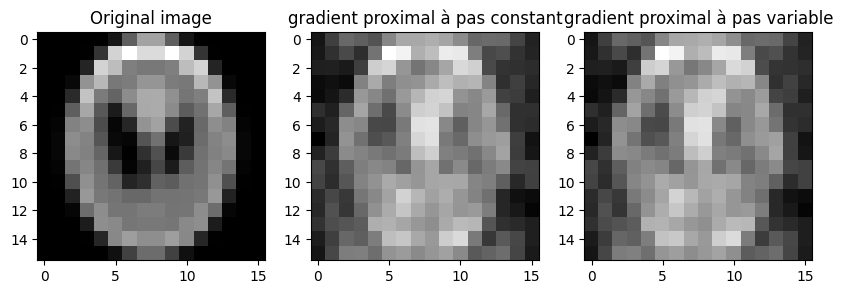

In [19]:
# Question 3.2.4.b)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
ax1.imshow(image_16,cmap='gray')
ax1.set_title('Original image')
ax2.set_title('gradient proximal à pas constant')
ax3.set_title('gradient proximal à pas variable')
# fonction
def g(f):
    return np.linalg.norm(np.dot(M,f)-m,2)**2
def prox_mu_h1(f, mu):
    return f/(1 + 2 * mu)
def h1(f):
    return np.linalg.norm(f, 2)**2
def grad_g(f):
    return np.dot(np.transpose(M), np.dot(M, f) - m)

# initialisation
x0=np.linalg.inv(F).dot(m0).real
# paramètres de l'algorithme de gradient proximal à pas constant
L=2
mu=1e-6
n_iter=1000

# résolution
x=x0
time_start = time.time()
assert mu<=1/L
for i in range(n_iter):
  x=prox_mu_h1(x-mu*grad_g(x),mu)
time_end = time.time()
sol_1=x.real.reshape(N,N)
ax2.imshow(sol_1,cmap='gray')

# paramètres de l'algorithme de gradient proximal à pas variable
n_iter=10000
l0=1e-5
eta=0.9
g0= g(x0)
r=grad_g(x0)
x=x0
l=l0
time_start = time.time()
# résolution
for _ in range(n_iter):
    while True:
        z = prox_mu_h1(x - l * r, l)
        g_hat = g0 + np.dot(r, z - x) + 1/(2*l) * np.linalg.norm(z - x)**2
        if g(z) <= g_hat:
            break
        l = eta * l
    x = z
    g0 = g(z)
    r = grad_g(z)
time_end = time.time()
print(time_end-time_start)
sol_2=x.real.reshape(N,N)
ax3.imshow(sol_2,cmap='gray')

### Q3.2.4.c)

4.5980918407440186


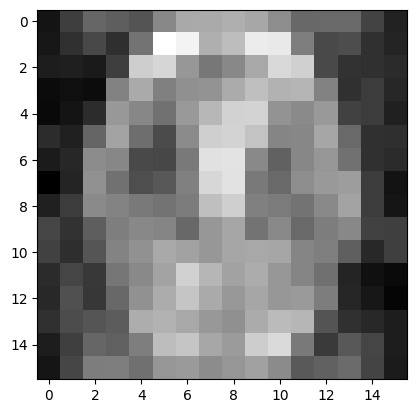

In [20]:
from skimage.restoration import denoise_tv_chambolle

Q=np.dot(np.conjugate(np.transpose(M)), M)+np.dot(np.transpose(M),np.conjugate(M))
Q=Q.real
a=-np.dot(np.transpose(M),np.conjugate(m)).real

# Définir la fonction objectif et son gradient
def f(x): 
    return 1/2*np.dot(np.transpose(x), Q, x) + np.dot(np.transpose(a), x) + 1/2*np.linalg.norm(m)**2

def grad_f(x):
    return np.dot(Q, x) + a

# Définir l'opérateur proximal de la variation totale
def prox_tv(x, weight):
    return denoise_tv_chambolle(x, weight=weight)

# Définir les paramètres de la méthode
x0 = np.linalg.inv(F).dot(m0).real

l=1e-7
n_iter = 10000
x=x0
time_start = time.time()
# Appliquer la méthode de gradient proximal
for _ in range(n_iter):
    x=x - l*grad_f(x)
    x=x.reshape(N,N)
    x = prox_tv(x, l)
    x=x.ravel()
time_end = time.time()
print(time_end-time_start)

sol=x.reshape(N,N)
plt.imshow(sol,cmap='gray')

### Q3.2.5)
On observe que pour tout $N$ la méthode des gradients proximaux est la plus efficace en termes de rapidité avec un temps d'execution plus rapide. En revanche la méthode utilisant cvx opt est la plus perforamante en terme de reconstitution : pour N=16 la reconstitution était déjà très efficace mais pour N=32 le résultat est trèsz proche de l'image d'origine.
En conclusion :
- la méthode des moindres carrés est un bon compromis entre temps d'exécution et reconstitution mais l'augmentation du nombre de pixel n'améliore considérablement la reconstitution. On a aussi l'apparition d'une sorte de bruit.
- la méthode utilisant casadi fournit un résultat satisfaisant mais avec un temps d'execution trop élevé.
- la méthode de QP est la meilleure en terme de fidélité de reconstitution, néanmoins le temps d'éxecution est très élevé particulièement quand N devient grand.
- les méthodes de gradients proximaux sont les meilleurs compromis selon nous car l'image reconsituée est fidèle à l'originel( sans être au niveau du QP) pour un temps d'execution raisonnable (même le plus rapide)